# Distance fluctuation analysis

## Aim

A fitting free method that is able to detect transiently stable conformations without any assumtion on the residues invoved, the actual confromation they take or the life time of the fold. In this method, the folded structure does not need to be a continuous stretch of residues or fold any part of it at the same time. However, proximity is also not a requirement, these residues do not need to touch just simply hold a relatively stable distance.

## The gist of the method

An IDP constantly changes it's confomration. However, some segments can temporarely fold into some kind of conformation. In this subset of residues, distances between residues are relatively stable (small variance) compared to the rest of the protein. Taken a time window of sufficient size e.g. 100 ns and all the residue to residue distances (e.g. using Cα coordinates) in this time frame the standard deviation of the distances will be smaller to residue pairs being part of the folded segment. Because we can always use distances belonging to a particular residue the drop in fluctuation is assigned to individual residues. Sliding the window over the simulation trajectory the stable segments are detected over the sequence and over time.

Because immediate residue neghbors are always at a fixed distance the first few neghbors are excluded from the analysis. Moreover, we are probably interested in conformations containing more than a few residues which can be done by first sorting the distance deviations belonging to a particualr residue and using e.g. the 10th smallest value for indication. By that we will find folded confomrmations containing at least 10 residues which corresponds roughly to a 2 turn α-helix.  

## Python code

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pyemma # for the coordinate handling
from bottleneck import  move_std # for running std calculation

In [8]:
#window size in frames
window_size = 1000 # this is 100 ns for this trajectory
#entity size - at least how big the folded conformation should be in number of residues
entity_size = 10

# setup pyemma featureizer and read in all Cα-Cα distances except for immediet neighors up to 2
in_topology = "../sample_data/topology.pdb"
in_trajectory = "../sample_data/sample_traj.xtc"
outfile = "test_distance_fluctuation_map"

feat = pyemma.coordinates.featurizer(in_topology)
feat.add_distances_ca(periodic=False, excluded_neighbors=2)
list_of_distances = feat.describe() #list distances will be used to select the distances belonging to a particular residue
data = pyemma.coordinates.load(in_trajectory, features=feat)

#result container, shape: time × residues
distance_fluctuation_map = np.zeros((data.shape[0]-(window_size-1),feat.select_Ca().size)) 

In [12]:
#iterate for all residues assuming a starting residue of 1 and continuous sequence
for R in range(1, feat.select_Ca().size + 1): 
    #select distances of interest
    SELECTION = " " + str(R) + " CA"
    #index of distance of interest
    ind = [i for i,item in enumerate(list_of_distances) if SELECTION in item]
    subset = data[:, ind]
    #moving std using bottleneck
    moving_std = move_std(subset, window_size, min_count=None, axis=0, ddof=0)
    #the first window_size-1 elements are NAN
    #leave out NaNs and sort by line (time)
    sorted_moving_std = np.sort(moving_std[window_size-1:,:],axis=1)
    #store the entity_size indicated fluctuation value
    distance_fluctuation_map[:,R-1] = sorted_moving_std[:,entity_size - 1 ]  
      


The obtained map can be saved of course for further processing e.g. measure time spent in stable entities of the different residue using a stability cutoff (<0.15 is a good value to start with).

Let's check out how our map looks like. The code below is optimized for this specific protein and trajecotry length.

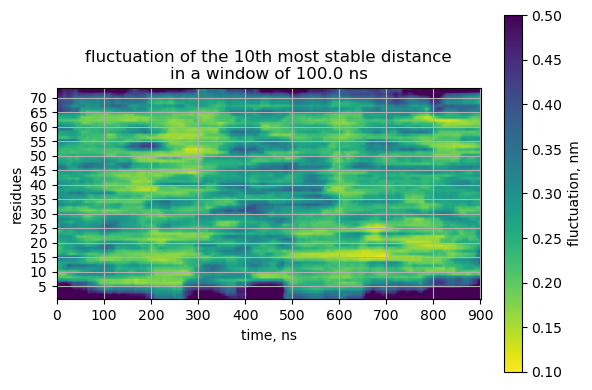

In [20]:
fig = plt.figure(figsize=(6,4))
#show map, we nned to rotatie it to have time as the x axis
#the aspect ratio is also computationally set as the two dimensions are different in magnitude
plt.imshow(np.rot90(distance_fluctuation_map),aspect=distance_fluctuation_map.shape[0] / distance_fluctuation_map.shape[1] / 2,
          vmin = 0.1, vmax = 0.5, cmap="viridis_r")
plt.grid()
#set time ticks to 100 ns
plt.xticks( np.arange(0,distance_fluctuation_map.shape[0],1000).tolist() , 
            np.arange(0,distance_fluctuation_map.shape[0]//10 + 1,100).tolist() )
#indicate every 5th residue
plt.yticks( np.arange(68,0,-5).tolist() , np.arange(5,73,5).tolist() )
plt.title(f"fluctuation of the {entity_size}th most stable distance\nin a window of {window_size*0.1} ns")
plt.xlabel("time (ns)")
plt.ylabel("residues")
plt.colorbar(orientation='vertical', label='fluctuation, nm', fraction=0.05, pad = 0.05)
plt.tight_layout()
